In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import random

In [55]:
path = r"C:\Users\PC\Desktop\data\[CONFIDENTIAL] AI symptom picker data (Agnos candidate assignment) - ai_symptom_picker.csv"
df = pd.read_csv(path)

In [57]:
df['summary_dict'] = df['summary'].apply(json.loads)
df['yes_symptoms_texts'] = df['summary_dict'].apply(lambda x: [item['text'] for item in x['yes_symptoms']])

In [58]:
df['summary_dict'] = df['summary'].apply(json.loads)
df['yes_symptoms_texts'] = df['summary_dict'].apply(lambda x: [item['text'] for item in x['yes_symptoms']])
df['yes_symptoms_texts'] = df['yes_symptoms_texts'].apply(
    lambda x: [item for item in x if item not in ['การรักษาก่อนหน้า', 'ประวัติอุบัติเหตุ']]
)
df = df[~df['yes_symptoms_texts'].astype(str).str.contains(r'[A-Za-z]')].reset_index(drop=True)
df['yes_symptoms_texts'] = df['yes_symptoms_texts'].apply(lambda x: ', '.join(x))
df['yes_symptoms_texts'] = df['yes_symptoms_texts'].str.replace(',', ' ').str.lower().str.strip()

df['search_term'] = df['search_term'].astype(str).str.split(',')
df['search_term'] = df['search_term'].apply(lambda x: [s.strip() for s in x])
df = df.explode('search_term').reset_index(drop=True)

In [60]:
counts = df['search_term'].value_counts()
rare_classes = counts[counts < 2].index
df_balanced = df.copy()
for cls in rare_classes:
    cls_df = df[df['search_term'] == cls]
    n_samples = 5 - len(cls_df)
    if n_samples > 0:
        duplicated = cls_df.sample(n=n_samples, replace=True, random_state=42)
        df_balanced = pd.concat([df_balanced, duplicated], ignore_index=True)

X = df_balanced[['age', 'gender', 'yes_symptoms_texts']]
y = df_balanced['search_term']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [61]:
numeric_features = ['age']
numeric_transformer = StandardScaler()

categorical_features = ['gender']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_features = 'yes_symptoms_texts'
text_transformer = TfidfVectorizer(max_features=500)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)
    ]
)

In [62]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

In [82]:
clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=4,
    n_estimators=100,
    learning_rate=0.1
)


In [83]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

pipeline.fit(X_train, y_train_enc, classifier__sample_weight=sample_weights)

c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [05:00:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [88]:
y_prob = pipeline.predict_proba(X_test)
classes = le.classes_

best_thresholds = {}
y_pred = np.zeros_like(y_prob, dtype=int)

for i, cls in enumerate(classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    f1_scores = []
    for t in thresholds:
        tmp_pred = (y_prob[:, i] >= t).astype(int)
        f1_scores.append(f1_score((y_test_enc == i).astype(int), tmp_pred))
    best_t = thresholds[np.argmax(f1_scores)]
    best_thresholds[cls] = best_t
    y_pred[:, i] = (y_prob[:, i] >= best_t).astype(int)

final_pred_enc = []
for row, row_prob in zip(y_pred, y_prob):
    if row.sum() == 0:
        idx = np.argmax(row_prob)
    else:
        idx = np.where(row == 1)[0][0]
    final_pred_enc.append(idx)

final_pred = le.inverse_transform(final_pred_enc)

print("Best thresholds per class:", best_thresholds)
print(classification_report(y_test, final_pred))

c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desk

Best thresholds per class: {'': np.float64(0.1), 'กระแทก': np.float64(0.1), 'กลืนติด': np.float64(0.1), 'กลืนลำบาก': np.float64(0.1), 'กลืนเจ็บ': np.float64(0.1), 'การได้ยินลดลง': np.float64(0.1), 'ก้อนที่ขา': np.float64(0.1), 'ก้อนที่ผิวหนัง': np.float64(0.1), 'ก้อนที่รักแร้': np.float64(0.1), 'ก้อนที่ศีรษะ': np.float64(0.2), 'ก้อนที่หลังหู': np.float64(0.1), 'ก้อนบริเวณขาหนีบ': np.float64(0.1), 'ก้อนบริเวณท้องน้อยปวดท้อง': np.float64(0.1), 'ก้อนบริเวณใบหน้า': np.float64(0.1), 'ขาบวม': np.float64(0.2), 'ขี้ตาเยอะ': np.float64(0.1), 'คลื่นไส้': np.float64(0.1), 'คลื่นไส้อาเจียน': np.float64(0.1), 'คอแดง': np.float64(0.1), 'คอแห้ง': np.float64(0.1), 'คอแห้งคอแดง': np.float64(0.1), 'คัดจมูก': np.float64(0.1), 'คัดจมูกมีเสมหะ': np.float64(0.1), 'คัดจมูกไอ': np.float64(0.1), 'คัน': np.float64(0.1), 'คันคอ': np.float64(0.1), 'คันคอมีเสมหะ': np.float64(0.30000000000000004), 'คันคอเสมหะไหลลงคอ': np.float64(0.1), 'คันจมูก': np.float64(0.2), 'คันจมูกจามบ่อย': np.float64(0.1), 'คันจมูกน้ำมูกไหล'

c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desk

In [16]:
y_train_prob = pipeline.predict_proba(X_train)

y_train_pred = np.zeros_like(y_train_prob, dtype=int)

for i, cls in enumerate(classes):
    threshold = best_thresholds[cls]
    y_train_pred[:, i] = (y_train_prob[:, i] >= threshold).astype(int)

final_train_pred_enc = []
for row, row_prob in zip(y_train_pred, y_train_prob):
    if row.sum() == 0:
        idx = np.argmax(row_prob)
    else:
        idx = np.where(row == 1)[0][0]
    final_train_pred_enc.append(idx)

final_train_pred = le.inverse_transform(final_train_pred_enc)

print("Train set classification report:")
print(classification_report(y_train, final_train_pred))

Train set classification report:
                                 precision    recall  f1-score   support

                                      0.00      0.00      0.00        81
                         กระแทก       0.15      1.00      0.27         2
                        กลืนติด       1.00      1.00      1.00         4
                      กลืนลำบาก       0.25      1.00      0.40         4
                       กลืนเจ็บ       0.60      0.60      0.60         5
                  การได้ยินลดลง       1.00      1.00      1.00         2
                      ก้อนที่ขา       1.00      1.00      1.00         2
                 ก้อนที่ผิวหนัง       1.00      1.00      1.00         3
                  ก้อนที่รักแร้       1.00      1.00      1.00         2
                   ก้อนที่ศีรษะ       1.00      1.00      1.00         4
                  ก้อนที่หลังหู       0.67      1.00      0.80         2
               ก้อนบริเวณขาหนีบ       1.00      1.00      1.00         4
      ก้อนบริเวณท

c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\PC\Desktop\ETL\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:

symptom_options = [
    ['เสมหะ', 'ไอ'],
    ['ไอ', 'น้ำมูกไหล'],
    ['ปวดท้อง'],
    ['น้ำมูกไหล'],
    ['ตาแห้ง'],
    ['ปวดกระดูก'],
    ['น้ำมูกไหล', 'ไอ'],
    ['ปวดท้อง'],
    ['เจ็บคอ', 'ไอ'],
    ['ไอ'],
    ['อาเจียน'],
    ['ปวดเมื่อยกล้ามเนื้อ'],
]

n_samples = 5


new_data_list = []

for _ in range(n_samples):
    age = random.randint(1, 100)  
    gender = random.choice(['male', 'female'])  
    symptoms = random.choice(symptom_options)
    symptoms_str = ", ".join(symptoms)
    
    new_data_list.append({
        'age': age,
        'gender': gender,
        'yes_symptoms_texts': symptoms_str
    })

new_data = pd.DataFrame(new_data_list)


new_data['yes_symptoms_texts'] = new_data['yes_symptoms_texts'].str.replace(',', ' ').str.lower().str.strip()


X_new_vec = preprocessor.transform(new_data[['age', 'gender', 'yes_symptoms_texts']])
y_new_prob = clf.predict_proba(X_new_vec)
classes = le.classes_

default_threshold = 0.1

y_new_pred_main = []
y_new_pred_top5 = []

for row in y_new_prob:
    filtered_idx = [i for i, prob in enumerate(row) if prob >= best_thresholds.get(classes[i], default_threshold)]
    
    
    if not filtered_idx:
        main_idx = np.argmax(row)
    else:
        main_idx = filtered_idx[np.argmax([row[i] for i in filtered_idx])]
    main_class = classes[main_idx]
    y_new_pred_main.append(main_class)
    
    
    top5_idx = [i for i in np.argsort(row)[::-1] if i != main_idx][:20]  # ดึงมากกว่า 5 ก่อน
    top5_classes = []
    for i in top5_idx:
        candidate = classes[i].strip()
        if not candidate or candidate in top5_classes or candidate == main_class:
            continue
        if main_class in candidate:
            continue
        if any(c in candidate or candidate in c for c in top5_classes):
            continue
        top5_classes.append(candidate)
        if len(top5_classes) >= 5:
            break

    y_new_pred_top5.append(", ".join(top5_classes) if top5_classes else "-")

new_data['predicted_main'] = y_new_pred_main
new_data['predicted_top5'] = y_new_pred_top5

print(new_data)


   age  gender   yes_symptoms_texts            predicted_main  \
0   71    male              ปวดท้อง                   แสบท้อง   
1   39    male            น้ำมูกไหล                 น้ำมูกไหล   
2   58    male                   ไอ                        ไอ   
3   40  female            ปวดกระดูก                 ปวดกระดูก   
4   91    male  ปวดเมื่อยกล้ามเนื้อ  ปวดเมื่อยกล้ามเนื้อทั่วๆ   

                                      predicted_top5  
0  เรอเปรี้ยว, จุกแน่นท้องปวดท้อง, คลื่นไส้, ก้อน...  
1  ไอไอกลางคืน, ปวดหัว, คันจมูกจามบ่อย, มึนศีรษะ,...  
2  ผิวแห้งผื่น, มีเสมหะน้ำมูกไหล, หูอื้อ, คัน, คั...  
3  มึนศีรษะ, ปวดหัวปวดท้ายทอย, ปวดกระบอกตา, ตาแห้...  
4          คัน, หูอื้อ, ฝ้าขาวที่ลิ้น, ผื่น, กลืนติด  


In [14]:
import joblib

joblib.dump(pipeline, "symptom_model.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

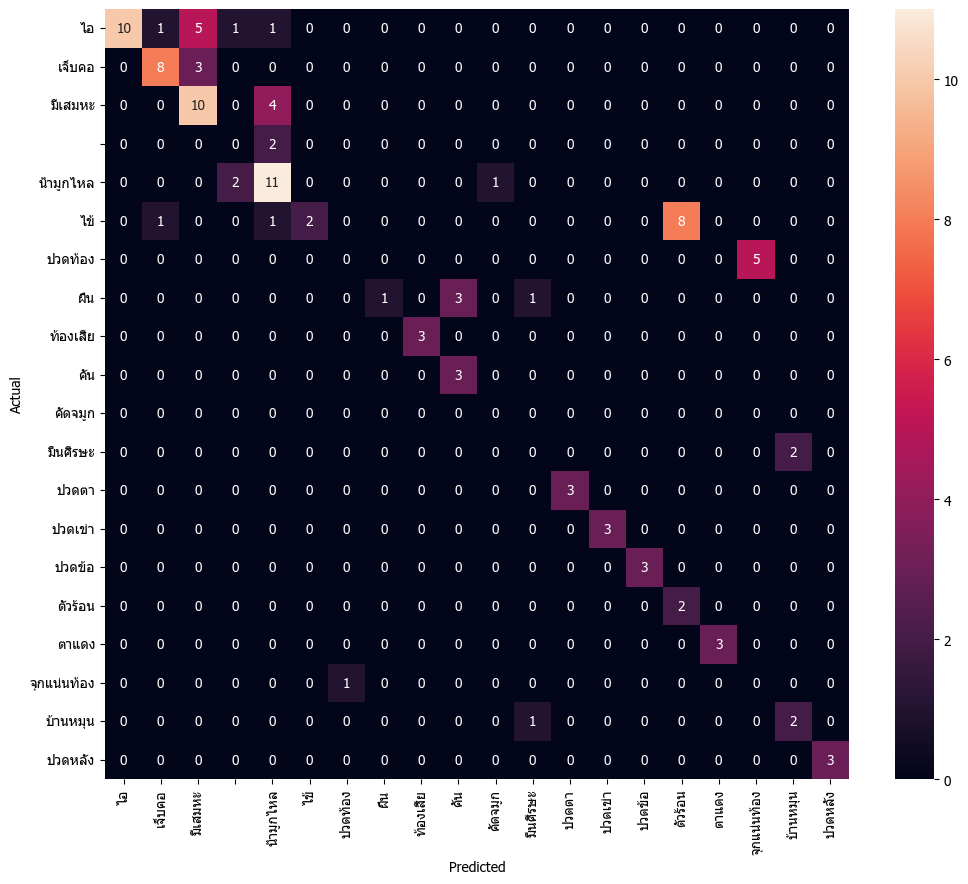

In [15]:
font_name = 'Tahoma' 
plt.rcParams['font.family'] = font_name

top_n = 20
top_classes = y_test.value_counts().index[:top_n]

final_pred_series = pd.Series(final_pred, index=y_test.index)  # align index

mask = y_test.isin(top_classes)

cm_top = confusion_matrix(
    y_test[mask],
    final_pred_series[mask],
    labels=top_classes
)

plt.figure(figsize=(12,10))
sns.heatmap(cm_top, annot=True, fmt='d', xticklabels=top_classes, yticklabels=top_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_14200\3789537319.py:2: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


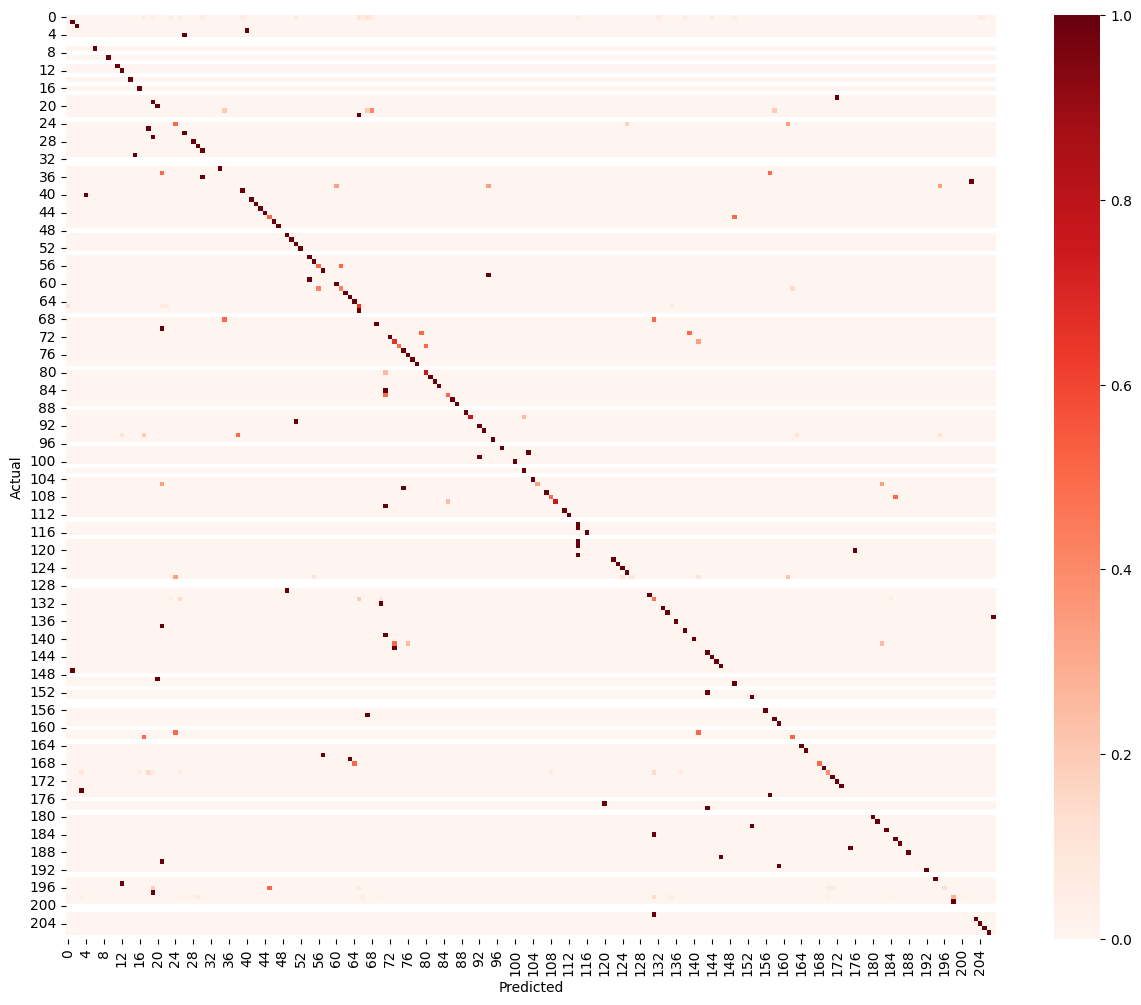

In [28]:
cm = confusion_matrix(y_test, final_pred, labels=le.classes_)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15,12))
sns.heatmap(cm_norm, annot=False, cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()